In [1]:
# Importing necessary Libraries.

import torch 
import torchvision
from torchvision.io import read_image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import time

- You can download the IITH logo from [IITH Logo1.jpeg](https://drive.google.com/file/d/1OykpG_G0X-Wgmzu0Rwd1zi5XfSkm7CaV/view?usp=sharing) but make sure you are using IITH email to access the file.

 # 1) Convolution Function

torch.Size([3, 407, 407])


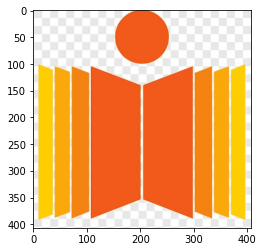

In [2]:
# image loading
start = time.time()
img = read_image("IITH Logo1.jpeg")
print(img.shape)
img_display = torch.einsum("chw->hwc",img)

plt.imshow(img_display)
plt.show()

In [3]:


def pad_func(img,pad):
  """ 
   pad_func takes image as input and depending on 'pad' it will pad all four sides of image.
   
   Arguments -> img : C x H x W (tensor)
                pad : int -> k pads 0 with pad_shape k x k.
                      tuple -> (a,b) or ((a,b),c) former pads 0 latter pads c with pad_shape (a,b).
  """
  channels  = img.shape[0]
  h = img.shape[1]
  w = img.shape[2]
    
   # Checking the type of pad.
  if isinstance(pad,tuple):
    if not isinstance(pad[0],tuple):
      h_pad = pad[0]
      w_pad = pad[1] if len(pad)==2 else 0
      value = 0
    else :
      pad_shape = pad[0]
      h_pad = pad_shape[0]
      w_pad = pad_shape[1] if len(pad_shape)==2 else 0
      value = pad[1]
  elif isinstance(pad,int):
    h_pad,w_pad = pad,pad
    value = 0
 

  new_img = torch.zeros(channels,h + 2*h_pad,w +2*w_pad)
    
  for c in range(channels) :
    
 # Padding the array rows 
   
    row_pad = torch.cat([torch.full((h_pad,w),float(value)),img[c],torch.full((h_pad,w),float(value))])

 # Padding the array columns

    new_img[c] = torch.cat([torch.full((h + 2*h_pad,w_pad),value),row_pad,torch.full((h + 2*h_pad,w_pad),value)],dim = 1)

        
        
  return new_img


In [4]:
# All activation functions used in Convolution.

def ReLU(x):

    return x*(x>0)

def PReLU(x,α = 0.05):
    return x*(x>0) + α*x*(x<0)

def Sigmoid(x):
    return 1 /(1 + torch.exp(-x))

def Tanh(x):
    return (torch.exp(x) - torch.exp(-x))/(torch.exp(x) + torch.exp(-x))

# activation function used to map the corresponding act func from the string.

def activation(string,x):
    if string == "ReLU":
        return ReLU(x)
    elif string == "PReLU":
        return PReLU(x)
    elif string == "Sigmoid":
        return Sigmoid(x)
    elif string == "Tanh":
        return Tanh(x)

In [5]:




def my_conv(input_img,kernel,bias = None ,stride = 1,padding = None,act_func = "ReLU"):
    """
    my_conv takes image and corresponding kernel and does 2D convolution.
    
    Arguments ->  input_img : C x H x W (tensor)
                  kernel : C x h x w (Here we are taking only one kernel)
                  bias : scalar value (defaults to None)
                  stride : (defaults 1)
                           int -> k  step_size for convolution will be (k,k) 
                           tuple -> (a,b) step_size for convolution will be (a,b)
                  padding : (defaults None) 
                            int  or tuple (same as pad_func)
                  act_func : (defaults ReLU)
                            str -> Takes standard names of activation function in string format 
    """
  
    c = kernel.shape[0]
    h = kernel.shape[1]
    w = kernel.shape[2]
        
    if not isinstance(padding,type(None)):
       
       input_img = pad_func(input_img,padding) # Padding
        
    C = input_img.shape[0]
    H = input_img.shape[1]
    W = input_img.shape[2]
    
    # Convolution starts 
    if isinstance(stride,tuple):
        h_step = stride[0]
        w_step = stride[1]
    else :
        h_step,w_step = stride,stride
        
    conv_img = torch.zeros(1,(H-h)//(h_step) + 1,(W-w)//(w_step) + 1)
  
    for i in range(h,H,h_step):
        for j in range(w,W,w_step):
          w_sum = torch.einsum("chw,chw->",input_img[:,i-h:i,j-w:j].to(torch.float32),kernel)
        
          if not isinstance(bias,type(None)):
              conv_img[0][(i-h)//h_step][(j-w)//w_step] = w_sum + bias
          else :
              conv_img[0][(i-h)//h_step][(j-w)//w_step] = w_sum
    
    # If activation function is Tanh then we are normalizing the conv image to avoid 'Nan' values.
    if act_func == "Tanh":
        conv_img = (conv_img - torch.min(conv_img))/(torch.max(conv_img) - torch.min(conv_img))
    act_conv_img = activation(act_func,conv_img)
   
    return act_conv_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


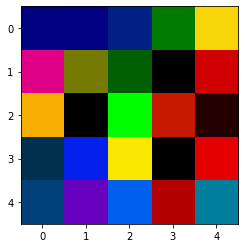

In [6]:
# Randomly generated kernel (values between (-1,1))

kernel = torch.rand(img.shape[0],5,5)*(-2) + 1

kernel_display = torch.einsum("chw->hwc",kernel)

plt.imshow(kernel_display)
plt.show()

In [7]:
# Verifying ReLU

act_conv_img1 = my_conv(img,kernel,padding = 2,stride = (2,2),act_func = "ReLU")


In [8]:
# Priniting the shapes of output activation.

print(act_conv_img1.shape)


torch.Size([1, 204, 204])


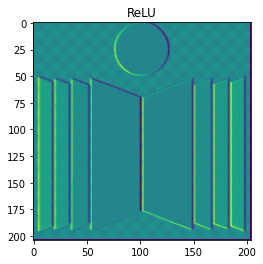

In [9]:
# Plotting each output activation

plt.title("ReLU")
plt.imshow(torch.einsum("chw->hwc",act_conv_img1))
plt.show()


# 2) Pooling Function

In [10]:
# Pooling options given for pooling

def Max_pool(img):
    return torch.max(img)

def Avg_pool(img):
    tot_sum = torch.einsum("chw->",img)
    avg = (tot_sum)/(img.shape[1]*img.shape[2])
    return avg

# Pool_operator manages which pool operation to choose.

def Pool_operator(img,pool_type):
    if pool_type == "Avg_pool":
        return Avg_pool(img)
    elif pool_type == "Max_pool":
        return Max_pool(img)

In [11]:

def Pooling(act_conv_output,kernel,stride = "same",pool_type = "Max_pool"):
    """
      Takes activated convoluted image and does pooling of special size given under given pooling option.
      
      Arguments -> act_conv_output : (1 x H x W ) output after convolution
                   kernel : tuple (dim of kernel)
                   stride : (defaults same, takes step size same as kernel dim)
                           int -> k  step_size for convolution will be (k,k) 
                           tuple -> (a,b) step_size for convolution will be (a,b)
                  pool_type : String format of standard pooling options
    """
    H = act_conv_output.shape[1]
    W = act_conv_output.shape[2]
    h = kernel[0]
    w = kernel[1]
    
    if isinstance(stride,tuple):
        h_step = stride[0]
        w_step = stride[1]
    elif isinstance(stride,int) :
        h_step,w_step = stride,stride
    elif stride =="same" :
        h_step,w_step = h,w
    if h_step >= h and w_step >=w :
    
     pooled_output = torch.zeros(1,(H-h)//(h_step) + 1,(W-w)//(w_step) + 1)
    
     for i in range(h,H,h_step):
       for j in range(w,W,w_step):
          pooled_output[0][(i-h)//h_step][(j-w)//w_step] = Pool_operator(act_conv_output[:,i-h:i,j-w:j],pool_type) 
    else :
        raise ValueError("Pooling operation should be done on non-overlapping regions Hint : Once check the stride ") 
          
    return pooled_output

In [12]:
# Demostration
pool_type = "Max_pool"

kernel_dim = (5,5)

pooled_img = Pooling(act_conv_img1,kernel_dim,stride = "same",pool_type = pool_type)


In [13]:
print(pooled_img.shape)

torch.Size([1, 40, 40])


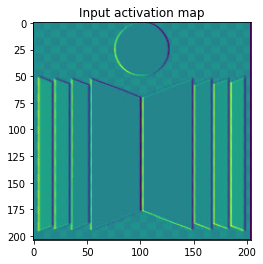

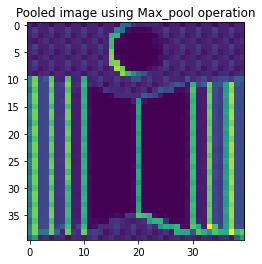

In [14]:
# Plot of output activation map and its pooled image
plt.figure(1)
plt.imshow(torch.einsum("chw->hwc",act_conv_img1))
plt.title("Input activation map")

plt.figure(2)
plt.imshow(torch.einsum("chw->hwc",pooled_img))
plt.title("Pooled image using {} operation".format(pool_type))


plt.show()

## 3) Convolution Layer 

In [15]:

def my_Conv_layer(input_vol,no_kernels,kernel_size,bias = None,stride = 1,padding = None,act_func = "ReLU"):
  """
  Conv_layer takes input volume and specified no.of kernels with their sizes and outputs activation maps and kernel volume.
  
  Arguments -> input_vol -> C x H x W
               no_kernels -> D
               kernel_size -> h x w (takes int or tuple but translates to h x w dimensions)
               bias -> D (default None)
               stride -> int or tuple - same as my_conv func
               padding -> int or tuple - same as my_conv func
               act_func -> Non-Linearity (defaults ReLU)
  """
  C = input_vol.shape[0]
  
  if isinstance(kernel_size,tuple):
      h = kernel_size[0]
      w = kernel_size[1] if len(kernel_size)==2 else kernel_size[0]
  
  elif isinstance(kernel_size,int):
        
    h,w = kernel_size,kernel_size
  
  kernel_vol = torch.rand(no_kernels,C,h,w)*(-2) + 1
  
  for c in range(no_kernels):
        act_conv = my_conv(input_vol,kernel_vol[c],bias = bias ,stride = stride,padding = padding,act_func = act_func)
        if c == 0 :
            act_con_vol = act_conv
        else :
            act_con_vol  = torch.cat([act_con_vol,act_conv])
  
  return act_con_vol,kernel_vol

In [16]:
out_act_maps,kernel_vol = my_Conv_layer(img,3,(5,5)) 

In [17]:
print("The dimensions of kernel volume ",kernel_vol.shape)

The dimensions of kernel volume  torch.Size([3, 3, 5, 5])


In [18]:
print("The dimensions of output activations ",out_act_maps.shape)

The dimensions of output activations  torch.Size([3, 403, 403])


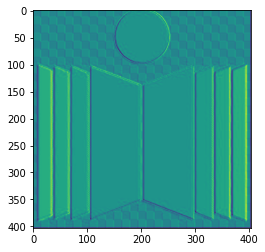

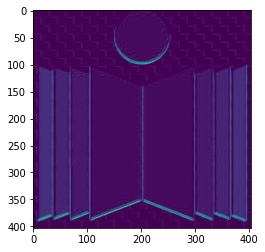

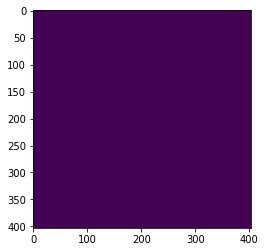

In [19]:
# Plotting the output activation maps.

for i in range(len(out_act_maps)):
  x = out_act_maps[i].reshape(1,out_act_maps[0].shape[0],out_act_maps[0].shape[1])
  plt.figure(i)
  plt.imshow(torch.einsum("chw->hwc",x))

plt.show()

# 4) Pooling Layer Function

In [20]:
def my_Pool_layer(act_conv_vol,kernel_dim,stride = "same",pool_type = "Max_pool"):
 """
  my_Pool_layer takes activation maps after convolution and returns the pooled activations.
  
   Arguments -> act_conv_vol : (C x H x W ) output after convolution
                kernel : tuple (dim of kernel)
                stride : same as Pooling func
                pool_type : same as Pooling func.
 """
 C = act_conv_vol.shape[0]
 for c in range(C):
   pooled_img = Pooling(act_conv_vol[c:c+1,:,:],kernel_dim,stride = stride,pool_type = pool_type)
   
   if c == 0:
      pooled_img_vol = pooled_img
   else :
     pooled_img_vol = torch.cat([pooled_img_vol,pooled_img])
 
 return pooled_img_vol

In [21]:
def GAP_layer(act_conv_vol):
 """
  Perfoms Global Average Pooling on the input activation maps.
  
  Argument -> act_conv_vol : (C x H x W)
 """
 C = act_conv_vol.shape[0]
    
 GAP_output = []

 for c in range(C):
        
    avg_out = Avg_pool(act_conv_vol[c:c+1,:,:])
    
    GAP_output.append(avg_out)
    
 return torch.tensor(GAP_output).reshape(len(GAP_output),1,1)

In [22]:
print(out_act_maps.shape)

torch.Size([3, 403, 403])


In [23]:
kernel_dim_layer = (10,10)

In [24]:
pooled_img_vol = my_Pool_layer(out_act_maps,kernel_dim_layer)


In [25]:
print(pooled_img_vol.shape)

torch.Size([3, 40, 40])


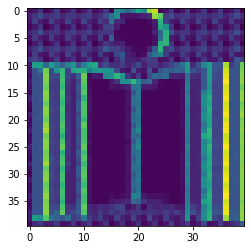

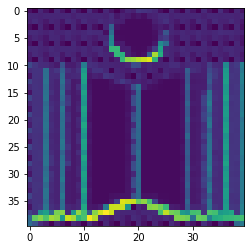

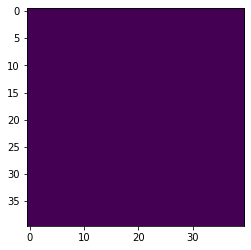

In [26]:
# Plotting each pooled channel

for i in range(len(pooled_img_vol)):
  x = pooled_img_vol[i:i+1,:,:]
  plt.figure(i)
  plt.imshow(torch.einsum("chw->hwc",x))

plt.show()

In [45]:
# Special Case using GAP Layer

GAP_output = GAP_layer(out_act_maps)

print(GAP_output)


tensor([[[410.2200]],

        [[ 32.3811]],

        [[  0.0000]]])


# 5) Flattening (unravel) Function 

In [28]:
def my_Unravel(img_vol,output_size):
    """
    my_Unravel takes image volume and return vector of specified output_size 
    Arguments : img_vol -> C x H x W
                output_size -> int or tuple
    """
    flatten = img_vol.reshape(-1,1)
    
    if isinstance(output_size,int):
        output_dim = output_size
    elif isinstance(output_size,tuple):
        output_dim = output_size[0]
    else :
        raise TypeError("expected int or tuple of shape a x 1.")
    
    transition_matrix = torch.rand(output_dim,flatten.shape[0])*(-2) + 1
    
    output_vec = torch.einsum("ij,jk->ik",transition_matrix,flatten)
    
    return output_vec

In [29]:
output_vec = my_Unravel(pooled_img_vol,(50,1))

In [30]:
print(output_vec.shape)

torch.Size([50, 1])


# 6) Multi Layer Perceptron (MLP) 

In [31]:
# Soft max function

def Soft_max(x):
    exp_array = torch.exp(x)
    return exp_array/sum(exp_array)

In [32]:
def my_MLP(input_vec,no_hidden,hidden_sizes,output_size,act_func = "ReLU",soft_max = True):
    """
    Arguments -> input_vec : D x 1 
                 no_hidden : d (int)
                 hidden_sizes : int(if no_hidden  = 1) or list of hidden sizes of each layer
                 output_size : c x 1 
                 act_func : Str
                 soft_max : bool for checking whether to do soft max or not.
    """
    bias = torch.tensor([1])
    
    input_vec = torch.cat((input_vec,bias.unsqueeze(0)))
    is_list = False
    if isinstance(hidden_sizes,list):
        is_list = True
        if no_hidden != len(hidden_sizes):
            raise ValueError("The number of the hidden layers is not matching with the list given")
    elif isinstance(hidden_sizes,int):
        if no_hidden != 1:
            raise ValueError("Expected 1 hidden layer but got {}".format(no_hidden))
    else :
        raise TypeError("Expected int or list but got {}".format(type(hidden_sizes)))
    
    hid_dim_prev = len(input_vec)
    
    weights = []
    
    # Generating weights between hidden layers
    
    if is_list :
        
        for layer in range(no_hidden):
            
            if isinstance(hidden_sizes[layer],tuple):
              if hidden_sizes[layer][1] == 1 :
                hid_dim_next = hidden_sizes[layer][0]  
              else :
                raise ValueError("Expected tuple shape of (dim,1)")
            elif isinstance(hidden_sizes[layer],int):
                hid_dim_next = hidden_sizes[layer]
            
            weight_layer = torch.rand(hid_dim_prev,hid_dim_next)*(-2) + 1 
            
            weights.append(weight_layer)
            hid_dim_prev = hid_dim_next
    else :
        hid_dim_next = hidden_sizes
        
        weight_layer = torch.rand(hid_dim_prev,hid_dim_next)*(-2) + 1
        
        weights.append(weight_layer)
        
        hid_dim_prev = hid_dim_next
        
    # Generating weights between last hidden layer and output layer
    
    if isinstance(output_size,tuple):
      if output_size[1] == 1 :
         out_dim = output_size[0] 
      else: 
         raise ValueError("Expected tuple shape of (dim,1)")
    elif isinstance(output_size,int):
        out_dim = output_size
    else :
        raise TypeError("Expected type -> int or tuple")
    
    weight_last = torch.rand(hid_dim_prev,out_dim)*(-2) + 1
    
    weights.append(weight_last)
    
    # Forward Pass 
    x_l = input_vec 
   
    
    for layer in range(len(weights)):
           s_l = torch.einsum("ij,ik->jk ",weights[layer],x_l)
           x_l = activation(act_func,s_l)
    
    # Checking Soft max
    if soft_max :
          output_vec = Soft_max(x_l)

    else :
        output_vec = x_l
    return output_vec
        

In [33]:
# Function Call and Output shape check

MLP_input = torch.rand(10,1)

MLP_output = my_MLP(MLP_input,5,[10,10,8,7,6],5,soft_max = True)

print(MLP_output.shape)

torch.Size([5, 1])


# 7) Feed-Forward Path

## Architecture of CNN

- Input image of size 32 × 32 × 3 from the CIFAR-10 dataset.
- Convolution layer with 16 kernels of size 3 × 3 spatial dimensions and sigmoid activation.
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
- Convolution layer with 8 kernels of spatial size 3 × 3 and sigmoid activation.
- Max pooling layer of size 2 × 2 with a stride of 2 along each dimension.
- A Global Average Pooling (GAP) layer.
- An MLP with one hidden layer (size same as input) that accepts as input the previous layer’s output and maps it to 10 output nodes. Used sigmoid activation for the MLP (softmax in the o/p layer).

In [34]:
# img is tensor obj with 3 x 32 x 32 dim

def FeedForwardPath(img):
     """
     FeedForwardPath takes multi channel image as input returns the flatten vector and output vector (after MLP)        using above CNN architecture.
     
     Arguments -> img : C x H x W 
     """
     kernel_no1 = 16
        
     kernel_dim1 = (3,3)
    
     act_conv_maps1,kernel_vol1 = my_Conv_layer(img,kernel_no1,kernel_dim1,bias = None,stride = 1,padding = None,act_func = "Sigmoid")
    
     pool_size1 = (2,2)

     pooled_img1 =  my_Pool_layer(act_conv_maps1,pool_size1,stride = "same",pool_type = "Max_pool")
     
     kernel_no2 = 8
    
     kernel_dim2 = (3,3)
        
     act_conv_maps2,kernel_vol2 = my_Conv_layer(pooled_img1,kernel_no2,kernel_dim2,bias = None,stride = 1,padding = None,act_func = "Sigmoid")
     
     pool_size2 = (2,2)
    
     pooled_img2 =  my_Pool_layer(act_conv_maps2,pool_size2,stride = "same",pool_type = "Max_pool")
    
     GAP_output  = GAP_layer(pooled_img2)
     
     flatten_output = torch.einsum("ijk->ij",GAP_output)
        
     MLP_input = flatten_output
    
     hidden_lyrs = 1
        
     hidden_dim = MLP_input.shape[0]
    
     output_nodes = 10 
        
     output_vec = my_MLP(MLP_input,hidden_lyrs,hidden_dim,output_nodes,act_func = "Sigmoid",soft_max = True)
     
     return flatten_output,output_vec

# 8) CNN (Forward Pass) On CIFAR-10 dataset

## Part - (a)

In [35]:
# Data Loading
data = torchvision.datasets.CIFAR10("./",download = True)

Files already downloaded and verified


In [36]:
# Taking data into 'imgs', respective labels to 'labels' and class names to 'classes'
imgs = data.data
imgs = torch.tensor(imgs)
imgs = torch.einsum("nhwc->nchw",imgs)

labels = data.targets

classes = data.classes

In [37]:
# To get image of each class
class_name = []

class_img = []

labels_lst = []
for i in range(len(labels)):
    if classes[labels[i]] not in class_name:
        labels_lst.append(labels[i])
        class_img.append(imgs[i])
        class_name.append(classes[labels[i]])
    if len(labels_lst) == 10 :
        break

In [38]:
print(class_name)

['frog', 'truck', 'deer', 'automobile', 'bird', 'horse', 'ship', 'cat', 'dog', 'airplane']


In [39]:
# Printing the output vectors.
for i in range(len(class_img)) :
    
    output_vec = FeedForwardPath(class_img[i])[1]
    
    print("The output vector of {} (class {}) is {}".format(class_name[i],labels_lst[i],output_vec))
    

The output vector of frog (class 6) is tensor([[0.1209],
        [0.0936],
        [0.0917],
        [0.1074],
        [0.1302],
        [0.1042],
        [0.0763],
        [0.1187],
        [0.0824],
        [0.0746]])
The output vector of truck (class 9) is tensor([[0.0638],
        [0.0730],
        [0.1234],
        [0.1211],
        [0.1164],
        [0.0971],
        [0.1079],
        [0.0753],
        [0.1033],
        [0.1188]])
The output vector of deer (class 4) is tensor([[0.0973],
        [0.1015],
        [0.0966],
        [0.0906],
        [0.1218],
        [0.1048],
        [0.0786],
        [0.0992],
        [0.1343],
        [0.0754]])
The output vector of automobile (class 1) is tensor([[0.1083],
        [0.0956],
        [0.1210],
        [0.1076],
        [0.0844],
        [0.0976],
        [0.0928],
        [0.0794],
        [0.0994],
        [0.1140]])
The output vector of bird (class 2) is tensor([[0.1318],
        [0.0866],
        [0.0941],
        [0.1121],
  

> As you can see , PMF of all classes after the CNN resembles the uniform distribution (every class is equally likely) since there is no learning.

## Part - (b)

> Since we are used a randomized network, there is no discriminability among classes it is evident in the above PMF(s)

In [40]:
each_class = [0]*10

label_index = []

flatten_outputs = torch.empty(30,8,1)

index = 0



for i in range(len(labels)):
    
    if each_class[labels[i]] != 3:
        
        label_index.append(labels[i])
        
        flatten_outputs[index] = FeedForwardPath(imgs[i])[0]
        
        each_class[labels[i]]+=1
        
        index+=1
        
    if len(set(each_class)) <= 1:
         break
  

>  SVD : $A = USV^T$

In [41]:
# Used torch.pca_lowrank

flatten_outputs = torch.einsum("ijk->ij",flatten_outputs)

U,S,V = torch.pca_lowrank(flatten_outputs)

In [42]:
print(U.shape)
print(S.shape)
print(V.shape)

torch.Size([30, 6])
torch.Size([6])
torch.Size([8, 6])


In [43]:
#  Choosing top 2 principal components.

flatten_outputs_2D = torch.einsum("ij,jk->ik",flatten_outputs,V[:,:2])


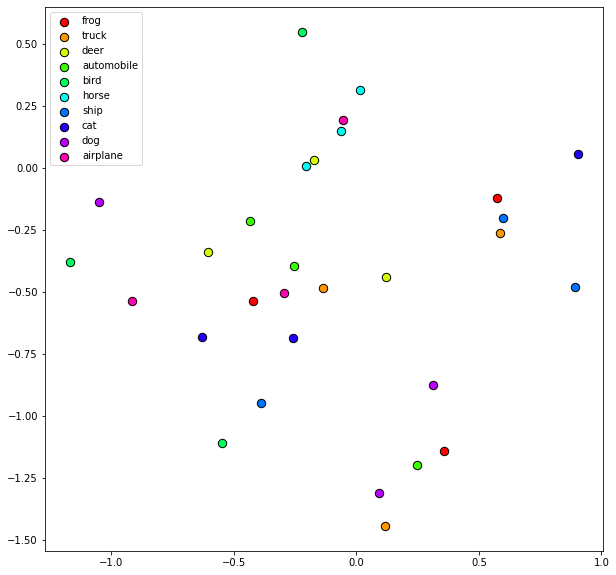

31.731704711914062


In [44]:
# Plotting the scatter plot of 30 images .

cmap = plt.cm.get_cmap('hsv',11)

class_x = [[flatten_outputs_2D[i][0] for i in range(len(label_index)) if j == label_index[i]] for j in range(len(class_name))]

class_y = [[flatten_outputs_2D[i][1] for i in range(len(label_index)) if j == label_index[i]] for j in range(len(class_name))]

# Increase the fig size for clearly legend if required.
plt.figure(figsize = (10,10))

for i in range(len(class_name)):
    plt.scatter(class_x[i],class_y[i],color = cmap(i),label = class_name[i],edgecolors = "black",s = 70)
plt.legend()
plt.show()
end = time.time()
print(end -start)